## CS 5180 Reinforcement Learning and Sequential Decision Making
### Exercise 6: Temporal-Difference Learning

In [1]:
import numpy as np
import environment
import algorithms
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import defaultdict

## Q2 Larger Random Walk

In [57]:
rw = environment.RandomWalk()
ideal_v_rw = np.arange(1/6, 5/6, 1/6)

lrw = environment.LargeRandomWalk()
ideal_v_lrw = np.arange(-0.9, 1, 0.10)

val_rw = {s:0 for s in rw.state_space}
val_lrw = {s:0 for s in lrw.state_space}

ten_episodes_rw = [algorithms.generate_episode(rw) for _ in range(10)]


episode = ten_episodes_rw[0]
for i in range(len(episode)-1):
    print(f"state = {episode[i][0]}    action = {episode[i][1].name}\treward = {episode[i][2]}")

state = C    action = RIGHT	reward = 0
state = D    action = RIGHT	reward = 0
state = E    action = RIGHT	reward = 1


#### We need a large random walk because as seen above, the episode of original small random walk could terminate in just in 3 steps. Since in the n-step TD algorithm, we do not make updates for the first n steps, any value of n > 2 would render the n-step algorithm useless and it would behave like a Monte Carlo algorithm. Hence we need a larger random walk to test the n-step TD algorithm over more values of n

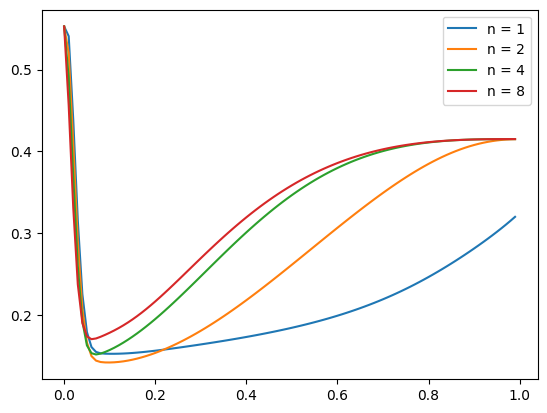

In [238]:
rms_rw = defaultdict(int)
alpha_range = np.arange(0, 1, 0.01)
n_range = [2**i for i in range(4)]

for a in alpha_range:
    for nn in n_range:
        est_v_rw = algorithms.n_step_td(rw, gamma=1, alpha=a, n=nn, episodes=ten_episodes_rw, V=val_rw)
        
        rms_rw[(a, nn)] = np.sqrt((np.square(list(est_v_rw.values())[1:-1] - ideal_v_rw)).mean())

for n in n_range:
    plt.plot(alpha_range, [rms_rw[(a, n)] for a in alpha_range], label = f"{n = }")

plt.legend()
plt.show()

#### Here, for the small random walk, it is can be seen that n=2 performs the best

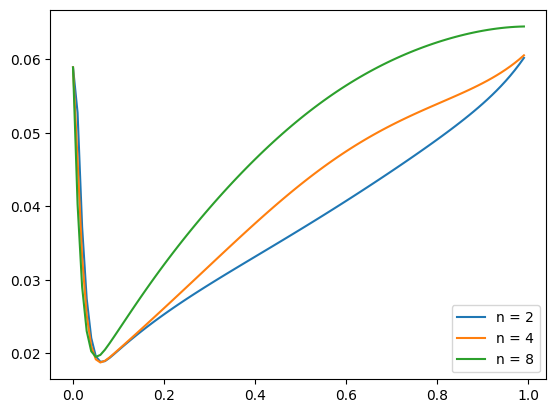

In [60]:
ten_episodes_lrw = [algorithms.generate_episode(lrw) for _ in range(10)]
rms_lrw = defaultdict(int)
alpha_range = np.arange(0, 1, 0.01)
n_range = [2**i for i in range(1, 4)]
    
for a in alpha_range:
    for nn in n_range:
        est_v_lrw = algorithms.n_step_td(lrw, gamma=1, alpha=a, n=nn, episodes=ten_episodes_lrw, V=val_lrw)
        rms_lrw[(a, nn)] = np.sqrt((np.square(list(est_v_lrw.values())[1:-1] - ideal_v_lrw)).mean())

for n in n_range:
    plt.plot(alpha_range, [rms_lrw[(a, n)]/10 for a in alpha_range], label = f"{n = }")

plt.legend()
plt.show()

#### Changing the value of the left terminal state would alter how the agent learns. I think the agent would probably be able to learn faster since it has a more negative incentive when going towards the wrong goal

## Q3 Windy Gridworld

In [3]:
def line_plot(array:np.ndarray, num_steps:int, num_trials:int, title:str) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    x = range(num_steps)
    y = np.mean(array, axis=0)
    ax.plot(y)
    std_error = np.std(array, axis = 0)/np.sqrt(num_trials)
    ax.fill_between(x, y + 1.96*std_error, y - 1.96*std_error, alpha = 0.3)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Number of episodes")
    ax.set_title(title)
    plt.show()

### Q3 (a) Implementation of the Windy gridworld domain

In [4]:
windy_world = environment.WindyWorld(stoc_wind=False, kings_moves=False, ninth_move=False)

num_actions = len(windy_world.action_space)
random_policy = {s:{a:1/num_actions for a in windy_world.action_space} for s in windy_world.state_space}

### Q3 (b) MC $\epsilon$-soft

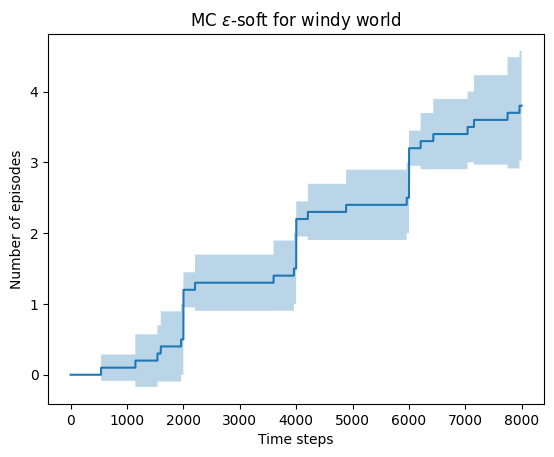

In [8]:
gamma = 1
num_steps = 8000
eps = 0.1
trials = 10
steps_vs_episode_mc = np.zeros([trials, num_steps], dtype=int)

for t in range(trials):
    e_soft_policy, steps_vs_episode_mc[t, :] = algorithms.mc_e_soft(windy_world, random_policy, gamma, num_steps, eps)

line_plot(steps_vs_episode_mc, num_steps, trials, "MC $\epsilon$-soft for windy world")

### Q3 (b) SARSA on-policy

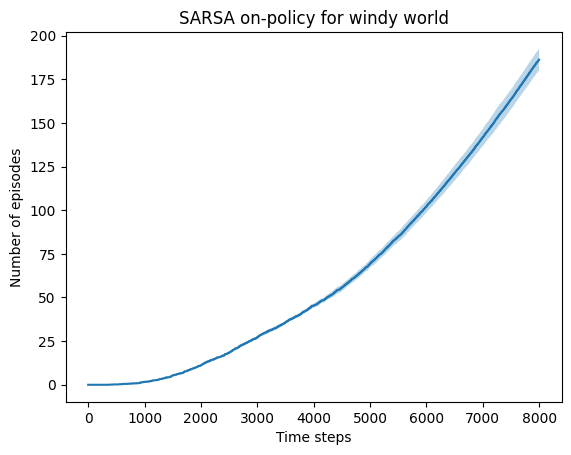

In [6]:
gamma = 1
num_steps = 8000
trials = 10
eps = 0.1
alpha = 0.5
steps_vs_episode_sarsa = np.zeros([trials, num_steps], dtype=int)

for t in range(trials):
    sarsa_policy, steps_vs_episode_sarsa[t, :], q_sarsa = algorithms.sarsa(windy_world, random_policy, gamma, num_steps, eps, alpha)

line_plot(steps_vs_episode_sarsa, num_steps, trials, "SARSA on-policy for windy world")

### Q3 (b) Q learning

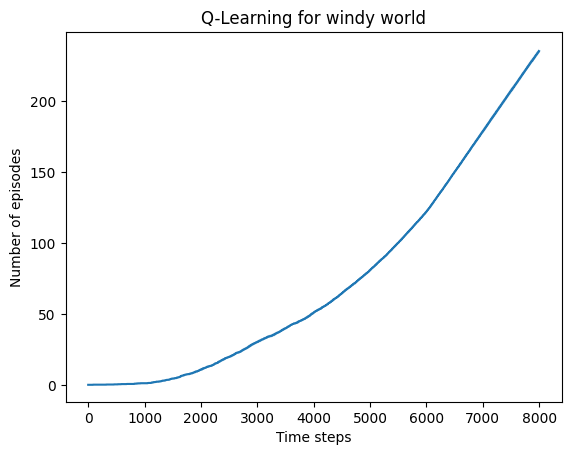

In [7]:
gamma = 1
eps = 0.1
alpha = 0.5
steps_vs_episode_q = np.zeros([trials, num_steps], dtype=int)

for t in range(trials):
    q_policy, steps_vs_episode_q[t,:], q_q = algorithms.q_learning(windy_world, random_policy, gamma, num_steps, eps, alpha)

line_plot(steps_vs_episode_q, num_steps, trials, "Q-Learning for windy world")

### Q3 (b) Expected SARSA

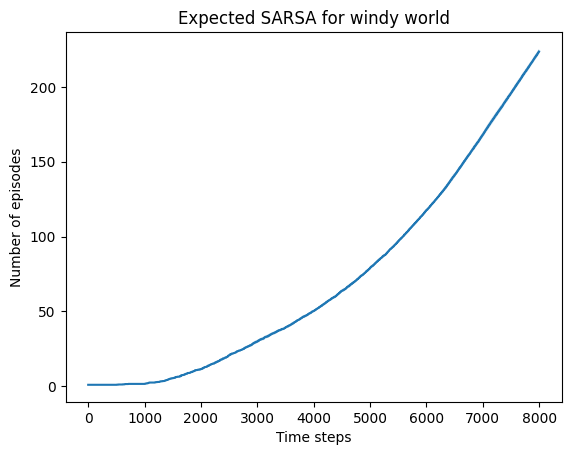

In [13]:
gamma = 1
eps = 0.1
alpha = 0.5
steps_vs_episode_exp_sarsa = np.zeros([trials, num_steps], dtype=int)

for t in range(trials):
    exp_sarsa_policy, steps_vs_episode_exp_sarsa[t, :], q_exp_sarsa = algorithms.exp_sarsa(windy_world, random_policy, gamma, num_steps, eps, alpha)

line_plot(steps_vs_episode_exp_sarsa, num_steps, trials, "Expected SARSA for windy world")

### Q3 (b) n-step SARSA

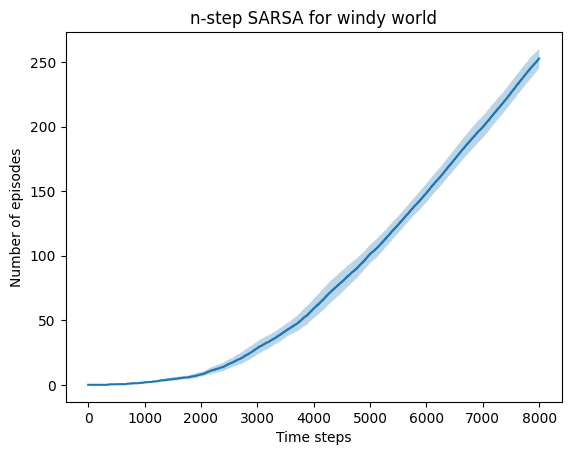

In [15]:
gamma = 1
eps = 0.07
alpha = 0.5
steps_vs_episode_n_sarsa = np.zeros([trials, num_steps], dtype=int)
n = 2

for t in range(trials):
    n_sarsa_policy, steps_vs_episode_n_sarsa[t, :], q_n_sarsa = algorithms.n_step_sarsa(windy_world, random_policy, gamma, num_steps, eps, alpha, n)

line_plot(steps_vs_episode_n_sarsa, num_steps, trials, "n-step SARSA for windy world")

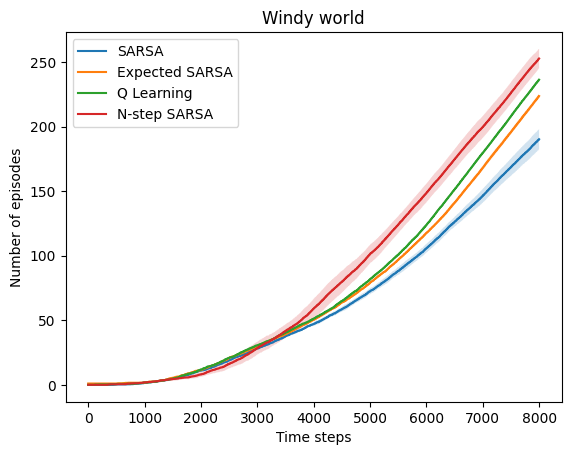

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
titles = ["SARSA", "Expected SARSA", "Q Learning", "N-step SARSA"]
for idx, data in enumerate([steps_vs_episode_sarsa, steps_vs_episode_exp_sarsa, 
                            steps_vs_episode_q, steps_vs_episode_n_sarsa]):
    y = np.mean(data, axis=0)
    ax.plot(y, label = titles[idx])
    std_error = np.std(data, axis=0)/np.sqrt(trials)
    ax.fill_between(range(num_steps), y + 1.96*std_error, y - 1.96*std_error, alpha = 0.2)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Number of episodes")

ax.legend()
ax.set_title("Windy world")
plt.show()

### Q3 (c) Windy gridworld with King’s moves

### Windy world with diagonal moves

In [43]:
windy_kings_moves = environment.WindyWorld(stoc_wind=False, kings_moves=True, ninth_move=False)

num_actions = len(windy_kings_moves.action_space)
random_policy = {s:{a:1/num_actions for a in windy_kings_moves.action_space} for s in windy_kings_moves.state_space}

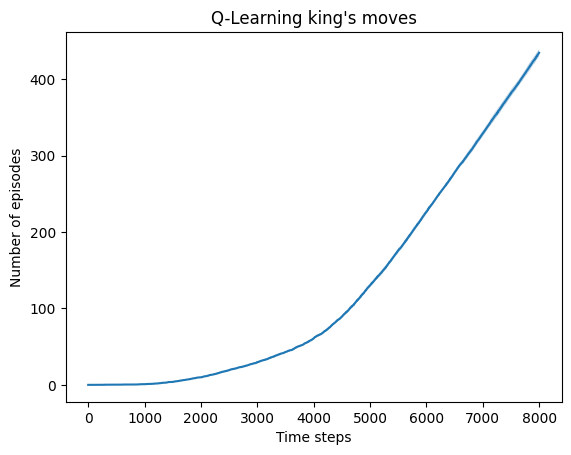

In [44]:
gamma = 1
eps = 0.1
alpha = 0.5
num_steps = 8000
steps_vs_episode_q_kings = np.zeros([trials, num_steps], dtype=int)

for t in range(trials):
    q_policy, steps_vs_episode_q_kings[t,:], q_q = algorithms.q_learning(windy_kings_moves, random_policy, gamma, num_steps, eps, alpha)

line_plot(steps_vs_episode_q_kings, num_steps, trials, "Q-Learning king's moves")

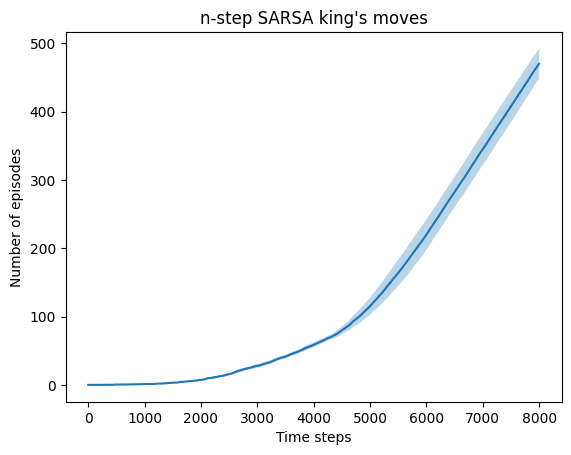

In [45]:
gamma = 1
eps = 0.01
alpha = 0.5
num_steps = 8000
steps_vs_episode_n_sarsa_kings = np.zeros([trials, num_steps], dtype=int)
n = 2

for t in range(trials):
    n_sarsa_policy, steps_vs_episode_n_sarsa_kings[t,:], q_n_sarsa = algorithms.n_step_sarsa(windy_kings_moves, random_policy, gamma, num_steps, eps, alpha, n)

line_plot(steps_vs_episode_n_sarsa_kings, num_steps, trials, "n-step SARSA king's moves")

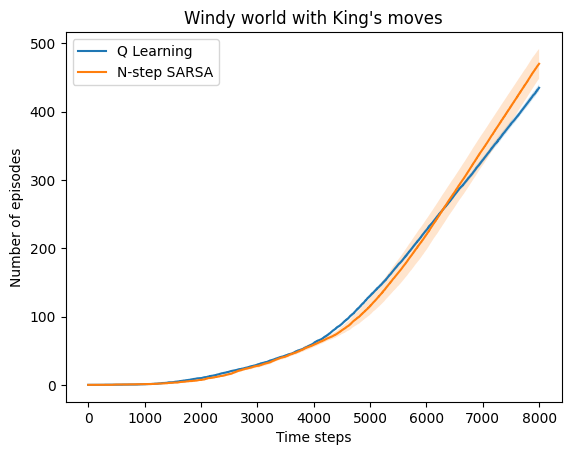

In [46]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
titles = ["Q Learning", "N-step SARSA"]
for idx, data in enumerate([steps_vs_episode_q_kings, steps_vs_episode_n_sarsa_kings]):
    y = np.mean(data, axis=0)
    ax.plot(y, label = titles[idx])
    std_error = np.std(data, axis=0)/np.sqrt(trials)
    ax.fill_between(range(num_steps),y + 1.96*std_error, y - 1.96*std_error, alpha = 0.2)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Number of episodes")

ax.legend()
ax.set_title("Windy world with King's moves")
plt.show()

### Windy world with King's move (extra move)

In [47]:
windy_ninth_move = environment.WindyWorld(stoc_wind=False, kings_moves=True, ninth_move=True)

num_actions = len(windy_ninth_move.action_space)
random_policy = {s:{a:1/num_actions for a in windy_ninth_move.action_space} for s in windy_ninth_move.state_space}

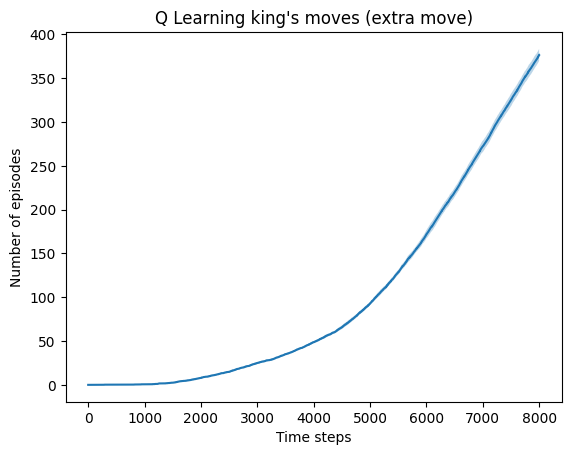

In [48]:
gamma = 1
eps = 0.1
alpha = 0.5
num_steps = 8000
steps_vs_episode_q_ninth = np.zeros([trials, num_steps], dtype=int)

for t in range(trials):
    q_policy, steps_vs_episode_q_ninth[t,:], q_q = algorithms.q_learning(windy_ninth_move, random_policy, gamma, num_steps, eps, alpha)

line_plot(steps_vs_episode_q_ninth, num_steps, trials, "Q Learning king's moves (extra move)")

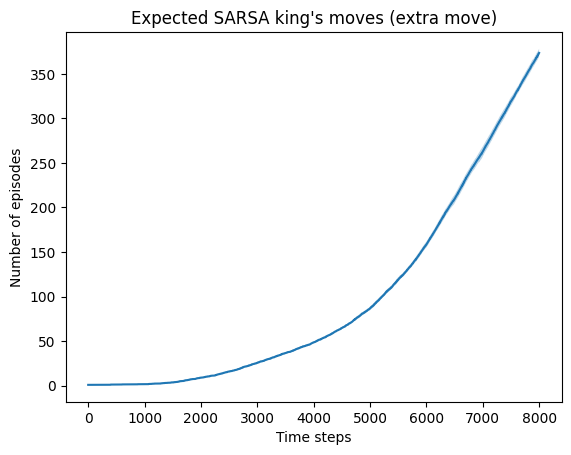

In [50]:
gamma = 1
eps = 0.1
alpha = 0.5
num_steps = 8000
steps_vs_episode_exp_sarsa_ninth = np.zeros([trials, num_steps], dtype=int)

for t in range(trials):
    exp_sarsa_policy, steps_vs_episode_exp_sarsa_ninth[t,:], q_exp_sarsa = algorithms.exp_sarsa(windy_ninth_move, random_policy, gamma,num_steps, eps, alpha)

line_plot(steps_vs_episode_exp_sarsa_ninth, num_steps, trials, "Expected SARSA king's moves (extra move)")

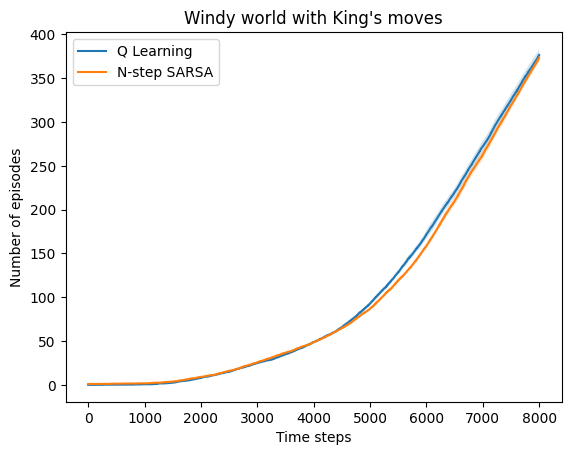

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
titles = ["Q Learning", "N-step SARSA"]
for idx, data in enumerate([steps_vs_episode_q_ninth, steps_vs_episode_exp_sarsa_ninth]):
    y = np.mean(data, axis=0)
    ax.plot(y, label = titles[idx])
    std_error = np.std(data, axis=0)/np.sqrt(trials)
    ax.fill_between(range(num_steps),y + 1.96*std_error, y - 1.96*std_error, alpha = 0.2)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Number of episodes")

ax.legend()
ax.set_title("Windy world with King's moves")
plt.show()

### Q3 (c) Windy world stochastic wind

In [52]:
windy_stoc = environment.WindyWorld(stoc_wind=True, kings_moves=True, ninth_move=True)

num_actions = len(windy_stoc.action_space)
random_policy = {s:{a:1/num_actions for a in windy_stoc.action_space} for s in windy_stoc.state_space}

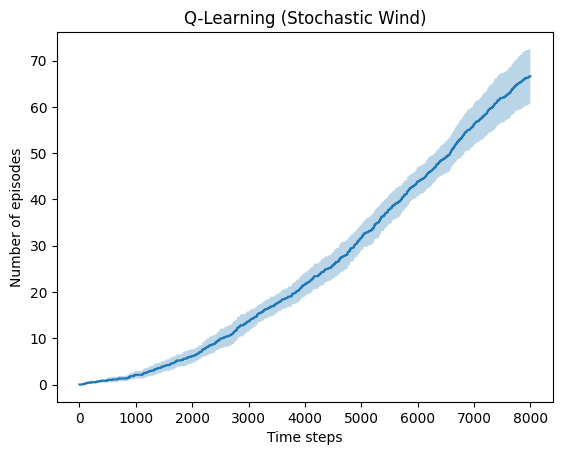

In [54]:
gamma = 1
eps = 0.1
alpha = 0.5
num_steps = 8000
steps_vs_episode_q_stoc = np.zeros([trials, num_steps], dtype=int)

for t in range(trials):
    q_policy, steps_vs_episode_q_stoc[t,:], q_q = algorithms.q_learning(windy_stoc, random_policy, gamma, num_steps, eps, alpha)

line_plot(steps_vs_episode_q_stoc, num_steps, trials, "Q-Learning (Stochastic Wind)")

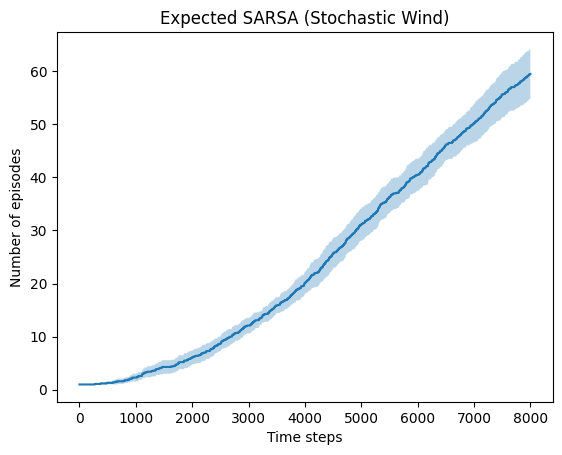

In [63]:
gamma = 1
eps = 0.1
alpha = 0.5
num_steps = 8000
steps_vs_episode_exp_sarsa_stoc = np.zeros([trials, num_steps], dtype=int)

for t in range(trials):
    exp_sarsa_policy, steps_vs_episode_exp_sarsa_stoc[t,:], q_exp_sarsa = algorithms.exp_sarsa(windy_stoc, random_policy, gamma,num_steps, eps, alpha)

line_plot(steps_vs_episode_exp_sarsa_stoc, num_steps, trials, "Expected SARSA (Stochastic Wind)")

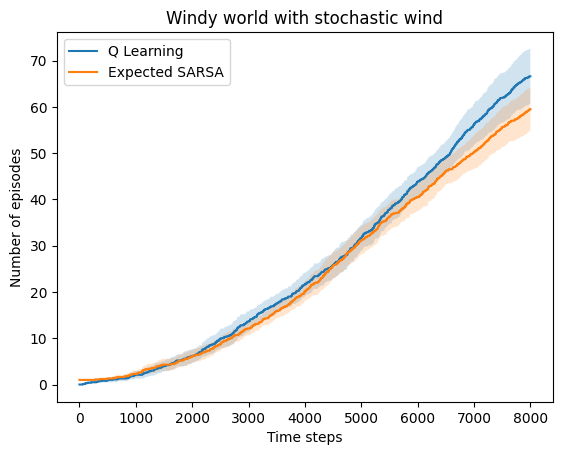

In [64]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
titles = ["Q Learning", "Expected SARSA"]
for idx, data in enumerate([steps_vs_episode_q_stoc, steps_vs_episode_exp_sarsa_stoc]):
    y = np.mean(data, axis=0)
    ax.plot(y, label = titles[idx])
    std_error = np.std(data, axis=0)/np.sqrt(trials)
    ax.fill_between(range(num_steps), y + 1.96*std_error, y - 1.96*std_error, alpha = 0.2)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Number of episodes")

ax.legend()
ax.set_title("Windy world with stochastic wind")
plt.show()

## Q4 Bias Variance Tradeoff

### Generating the training and evaluation episodes

In [187]:
N = [1, 10, 50, 100]
n_eval_episodes = 100

train_episodes = {}
eval_episodes = [algorithms.generate_episode(windy_world, q_policy) for _ in range(n_eval_episodes)]

val_0_td = {}
val_n_td = {}
val_mc = {}

for n in N:
    train_episodes[n] = [algorithms.generate_episode(windy_world, q_policy) for _ in range(n)]
    val_0_td[n] = algorithms.n_step_td(windy_world, gamma=1, alpha=0.5, n = 1, episodes=train_episodes[n])
    val_n_td[n] = algorithms.n_step_td(windy_world, gamma=1, alpha=0.5, n = 4, episodes=train_episodes[n])
    val_mc[n] = algorithms.mc_prediction(windy_world, gamma=1, episodes=train_episodes[n])

In [188]:
target_mc = {n:[] for n in N}
target_0_td = {n:[] for n in N}
target_n_td = {n:[] for n in N}

for episode in eval_episodes:
    next_state = episode[1][0]
    reward = episode[0][2]

    for n in N:
        target_mc[n].append(np.sum([e[2] for e in episode]))
        target_0_td[n].append(reward + val_0_td[n][next_state])
        target_n_td[n].append(np.sum([episode[i][2] for i in range(4)]) + val_n_td[n][next_state])

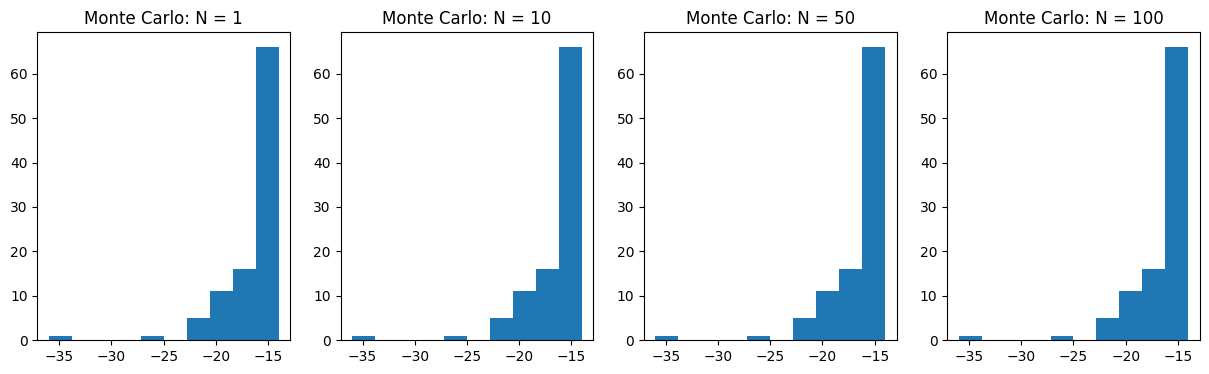

In [179]:
fig = plt.figure(figsize=(15, 4))

for axs, n in enumerate(N):
    ax = fig.add_subplot(1, len(N), axs+1)
    ax.hist(target_mc[n], bins=10)
    ax.set_title(f"Monte Carlo: N = {n}")


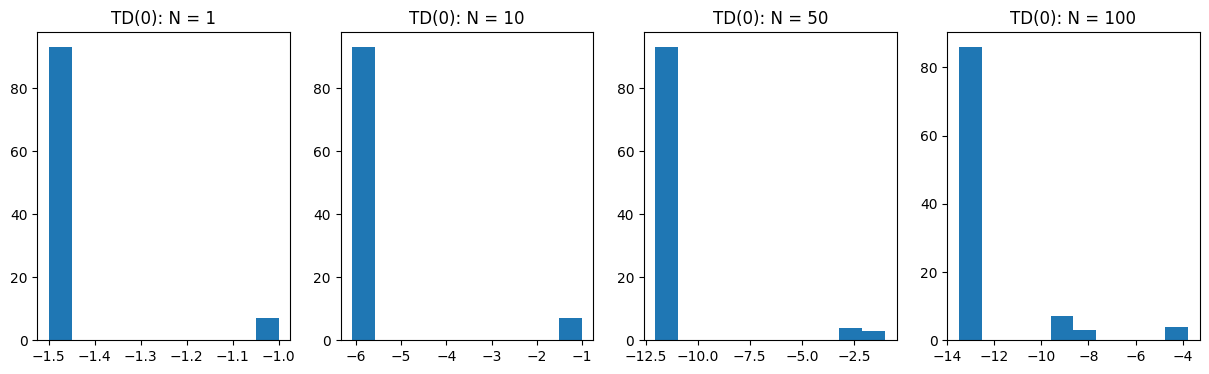

In [180]:
fig = plt.figure(figsize=(15, 4))

for axs, n in enumerate(N):
    ax = fig.add_subplot(1, len(N), axs+1)
    ax.hist(target_0_td[n], bins=10)
    ax.set_title(f"TD(0): N = {n}")


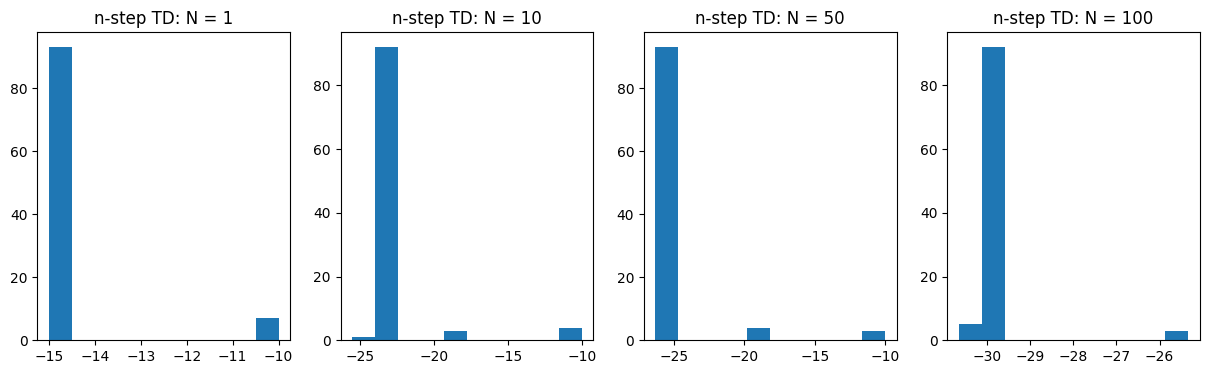

In [186]:
fig = plt.figure(figsize=(15, 4))

for axs, n in enumerate(N):
    ax = fig.add_subplot(1, len(N), axs+1)
    ax.hist(target_n_td[n], bins=10)
    ax.set_title(f"4-step TD: N = {n}")

### Q4 (b) Written
It can be clearly observed from the histograms of the Monte-Carlo method for all values of N that it is unbiased but has a high variance as seen by the spread of the histogram. Whereas in case of TD(0) method, the bias in the state value estimate is high when N=1 and N=10, but as N increases, the bias will decrease (with respect to the true state value) as seen in the histogram plot of N=50 and N=100. TD(0) is a low variance method since more than 90% of the estimated state values fall in the same bin. In case of n-step TD, the variance is greater than that of TD(0) for n=4, and the variance will increase as we increase the value of n, because then the n-step TD method will perform more and more like Monte Carlo method.